# Choosing Sample Sizes and Estimators in Studies of Online Behavior
J. Nathan Matias, January 2016

In my roles at Princeton University and CivilServant, I often conduct and teach students how to conduct power analyses of experiments. In this process, researchers state their assumptions about a study and what they want to be able to observe and work from those assumptions to make decisions about the study based on what is statistically-possible:
* deciding between different kinds of designs (what to measure, how many arms, comparisons, etc)
* deciding between different kinds of estimators
* deciding what sample size to use

In September 2018, I wrote a blog post about [estimating counts of events in behavioral product testing](https://medium.com/@natematias/estimating-counts-of-events-in-behavioral-product-testing-e3b68f6143e2). Since then, I have learned how to use [DeclareDesign](http://declaredesign.org/), software for designing and evaluating study designs, including power analyses. This followup notebook continues what I began in that post, by more systematically comparing linear, poisson, and negative binomial estimators using simulated parameters based on  a real study I conducted in 2016.

Note: studies of online behavior usually include count outcomes, so this example will exclusively focus on count outcomes. Mathematics in the utility functions are drawn from:
*  Long, J. Scott. 1997. [Regression Models for Categorical and Limited Dependent Variables](https://us.sagepub.com/en-us/nam/regression-models-for-categorical-and-limited-dependent-variables/book6071). 1 edition. Thousand Oaks: SAGE Publications, Inc.

I am grateful to my fellow postdoc [Jasper Cooper](http://jasper-cooper.com/) for presenting to the Paluck Lab last fall about how to use DeclareDesign, and to Neal Fultz, for [generously answering my questions on the DeclareDesign forum](http://discuss.declaredesign.org/t/subsetting-errors-in-a-glm-nb-multi-arm-experiment/60).

In [86]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(tidyverse)
library(DeclareDesign)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.1

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DeclareDesign_0.13.0 estimatr_0.14        fabricatr_0.6.0     
 [4] randomizr_0.16.1     forcats_0.3.0        stringr_1.3.1       
 [7] purrr_0.2.5          readr_1.3.1          tidyr_0.8.2         
[10] tibble_2.0.0         tidyverse_1.2.1      rlang_0.3.0.1       
[13] ggplot2_3.1.0        MASS_7.3-51.1        dplyr_0.7.8         

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 repr_0.19.1      haven_2.0.0     
 [5] lattice_0.20-38  generics_0.0.2   colorspa

### Utility Methods

In [87]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    mu*(irr-1)
}

# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param p the probability in question
betas.logit.from.prob <- function(p){
    log(p/(1-p))
}


# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param Y list of observed Ys
betas.logit.from.mean <- function(Y){
    p = mean(Y)
    log(p/(1-p))
}

# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}


### Utility method: Binary search for a target statistical power

In [88]:
# Conduct a binary search for a certain level of statistical power
# within the constraints of a configuration file
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @target.power The statistical power that ideally should be the minimum across the study
#` @target.tolerance How close to the desired statistical power is close enough?
#` @min.sample.diff If the binary search is considering a sample size difference smaller than min.sample.diff, end the search

search.for.power <- function(config.df, diagnosis.method = diagnose.multipop.multiarm, target.power = 0.85, target.tolerance = 0.01, min.sample.diff = 1000){

    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = as.integer(max.sample.size / 2)
    current.power = 0.0

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands 
    current.power <- min.diagnosis.power(ddf)

    if(current.power < target.power){
        min.sample.size = current.sample.size
        print(paste(current.power, "<", target.power))
    }else{
        max.sample.size = current.sample.size
        print(paste(current.power, ">", target.power))
    }   
        
    current.sample.size = min.sample.size + as.integer((max.sample.size - min.sample.size)/2)
        
    while(all.equal(target.power, current.power, tolerance = target.tolerance)!=TRUE){
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
        
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
            
        ## check the current statistical power and
        ## carry out the binary search by first updating the boundaries
        current.power <- min.diagnosis.power(ddf) 
        if(current.power < target.power){
            min.sample.size = current.sample.size
            print(paste(current.power, "<", target.power))
        }else{
            max.sample.size = current.sample.size 
            print(paste(current.power, ">", target.power))
        }
        ## update the current pointer, or break if
        ## the sample size difference is less than or equal
        ## to ten
        sample.size.diff <- as.integer((max.sample.size - min.sample.size)/2)
        if(abs(sample.size.diff) <= 1000){
            print(paste("Sample size difference", abs(sample.size.diff), "is <= ", min.sample.diff ," Ending cycle."))
            break
        }
        current.sample.size = min.sample.size + sample.size.diff
    }
    diagnoses.df
}


### Utility method: plot the power curve for the results of a binary search for statistical power

In [89]:
# Create a plot of each power analysis
#
#' @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}


## Example DeclareDesign definition
To diagnose a design with DeclareDesign, declare the basic assumptions about the study:
* simulating everything: 
 * a population
 * covariates
 * every potential outcome for every observation
 * assignment
 * estimands - what people sometimes describe as the expected "true effects"
 * "reveal step" simulates data collection, along with assumptions about incompleteness in data collection
 * estimators (the statistical tests you're using in the final estimation of results)
 
 Process
 * for one iteration of a power analysis:
     * create an experiment design object / simulation
     * diagnose the experiment design object
 * for a whole power analysis
     * create a bunch of designs at different sample sizes, etc
     * compare the diagnoses between them

### Define study assumptions
In this code example, I define some of the assumptions about the study in a dataframe that can then be adjusted and iterated as part of a power analysis. This is not required by DeclareDesign.

I have derived the mu and theta parameters for this simulation by using the [`fitdistr`](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/fitdistr.html) method in the `MASS` R library.

In [90]:
example.config <- data.frame(
    pa.label = "example.design",
    n.max = 200,
    n.min = 10000,
    
    YA.mu    = 7.680505605,
    YA.theta = 0.095880936,
    YA.effect.irr = exp(0.335)
)

In [91]:
design <-   declare_population(
                N = 500) +
            declare_potential_outcomes(
                YA_Z_0 = rnegbin(n=N, mu = example.config$YA.mu, 
                                 theta = example.config$YA.theta),
                YA_Z_1 = rnegbin(n=N, mu =  mu.diff.from.mu.irr(
                                                example.config$YA.mu,
                                                example.config$YA.effect.irr),
                                 theta = example.config$YA.theta)
            ) +
            declare_assignment(num_arms = 2,
                               conditions = (c("0", "1"))) +
            declare_estimand(ate_YA_1_0  = mean(YA_Z_1 - YA_Z_0)) +
            declare_reveal(outcome_variables = c("YA"))  +
            declare_estimator(log1p(YA) ~ Z, label="lm_log_YA 1/0") +
            declare_estimator(label = "Y90DayMinutes.nb 1/0", estimand="ate_YA_1_0", handler=tidy_estimator(function(data){
                subset(tidy(glm.nb(formula = YA ~ Z, data, subset = (Z %in% c(0,1)))), term == "Z1")   
            }))

#             declare_estimator(handler=tidy_estimator(function(data){
#                 m <- glm.nb(formula=YA ~ Z, data)
#                 out <- subset(tidy(m), term == "Z1")
#                 transform(out,
#                      conf.low = estimate - 1.96*std.error,
#                      conf.high = estimate + 1.96*std.error
#                 )
#             }), estimand="ate_YA_1_0")

In [92]:
design

ERROR while rich displaying an object: Error in UseMethod("tidy"): no applicable method for 'tidy' applied to an object of class "c('negbin', 'glm', 'lm')"

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. r

### View Design Details
DeclareDesign makes it possible to view a detailed log of the assumptions built into a specific research design, as well as the values generated by a single simulation of those assumptions. Here is an example:

In [54]:
design


Design Summary

Step 1 (population): declare_population(N = 500) -------------------------------

N = 500 

Added variable: ID 
 N_missing N_unique     class
         0      500 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rnegbin(n = N, mu = example.config$YA.mu,     theta = example.config$YA.theta), YA_Z_1 = rnegbin(n = N,     mu = mu.diff.from.mu.irr(example.config$YA.mu, example.config$YA.effect.irr),     theta = example.config$YA.theta)) 

Added variable: YA_Z_0 
 min median mean max    sd N_missing N_unique
   0      0 5.21 175 15.86         0       50

Added variable: YA_Z_1 
 min median mean max   sd N_missing N_unique
   0      0  2.5  88 8.42         0       33

Step 3 (assignment): declare_assignment(num_arms = 2, conditions = (c("0", "1"))) 

Added variable: Z 
    0    1
  250  250
 0.50 0.50

Added variable: Z_cond_prob 
  0.5
  500
 1.00

Step 4 (estimand): declare_estimand(ate_YA_1_0 = mean(YA_Z_1 - YA_Z_0)) --------

A single draw of the

### Diagnose Design
In DeclareDesign, the diagnosis step simulates the study a large number of times and generates diagnosis information for the research design.

In [52]:
diagnose_design(design, sims=500, bootstrap_sims=500)


Research design diagnosis based on 500 simulations. Diagnosand estimates with bootstrapped standard errors in parentheses (500 replicates).

 Design Label Estimand Label Estimator Label Term N Sims   Bias   RMSE  Power
       design     ate_YA_1_0       estimator    Z    500   4.37   4.54   0.68
                                                         (0.05) (0.05) (0.02)
 Coverage Mean Estimate SD Estimate Mean Se Type S Rate Mean Estimand
     0.00         -0.26        0.10    0.11        0.00         -4.63
   (0.00)        (0.00)      (0.00)  (0.00)      (0.00)        (0.05)

### Interpreting the diagnosis
DeclareDesign provides us with many very usful pieces of information for evaluating a given research design. Here are four that are especially useful:
* **Power**: The statistical power of the overall study design. As used here, power is the probability that the result from a given study will satisfy the decision rule (in this case, a statistically-significant result at alpha = 0.05)
* **Bias**: This result provides the average difference, across simulations, between the estimand (simulated "true effect") and the outcome of the estimation procedure. If a research procedure (including the estimator) is systematically biased within the parameters of the simulation, this result can show what that bias is. Like any simulation, the estimate of bias is more accurate at higher numbers of simulations
* **Coverage**: The probability that the estimand is included in the confidence intervals of the estimated result. This is especially useful when making decisions about the estimation procedure of a study
* **RMSE**: The root mean square error is the standard deviation of the difference between the estimator and the estimand across simulations. When comparing two estimators, a smaller root mean square error is better sqrt(mean((estimate - estimand)^2))


# Search for Power

In [1]:
# CONSTRUCT A DIAGNOSIS
#
#' @param n.size     the sample size to test
#' @param config.df  the configuration dataframe to use 
#' @param sims.count the number of simulations to carry out
#' @param bootstrap.sims.count the number of bootstraps for estimating the simulation test statistics  

diagnose.experiment <- function(n.size, config.df, sims.count=100, bootstrap.sims.count=100){
    design <-   declare_population(
                    N = n.size) +
                declare_potential_outcomes(
                    YA_Z_0 = rnorm(n=N, mean=config.df$YA.mean),
                    YA_Z_1 = rnorm(n=N, mean=config.df$YA.mean + config.df$YA.effect.a)
                ) +
                declare_assignment(num_arms = 2,
                                   conditions = (c("0", "1"))) +
                declare_estimand(ate_YA_1_0  = mean(YA_Z_1 - YA_Z_0)) +
                declare_reveal(outcome_variables = c("YA"))  +
                declare_estimator(YA ~ Z, model = lm, estimand="ate_YA_1_0")
#                 declare_estimator(label = "YA.lm 1/0", estimand = "ate_YA_1_0", handler = tidy_estimator(function(data){
#                     subset(tidy(lm(formula = YA ~ Z, data)), term="Z1")
#                 })) #+
#                declare_estimator(label = "YNA.nb 1/0", estimand="ate_YNA_1_0",     handler=tidy_estimator(function(data){
#                    subset(tidy(glm.nb(formula = YNA ~ Z, data, subset = (Z %in% c(0,1)))), term == "Z1")
#                }))
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [43]:
diagnose.experiment(200, experiment.config)

ERROR: Error in diagnose.experiment(100, experiment.config): could not find function "diagnose.experiment"


In [113]:
search.for.power <- function(config.df, diagnosis.method = diagnose.experiment, target.power = 0.85, target.tolerance = 0.01, min.sample.diff = 1000){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = as.integer(max.sample.size / 2)
    current.power = 0.0

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)

    if(current.power < target.power){
        min.sample.size = current.sample.size
        print(paste(current.power, "<", target.power))
    }else{
        max.sample.size = current.sample.size
        print(paste(current.power, ">", target.power))
    }

    current.sample.size = min.sample.size + as.integer((max.sample.size - min.sample.size)/2)
   while(all.equal(target.power, current.power, tolerance = target.tolerance)!=TRUE){
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()

        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)

        ## check the current statistical power and
        ## carry out the binary search by first updating the boundaries
        current.power <- min.diagnosis.power(ddf)
        if(current.power < target.power){
            min.sample.size = current.sample.size
            print(paste(current.power, "<", target.power))
        }else{
            max.sample.size = current.sample.size
            print(paste(current.power, ">", target.power))
        }
        ## update the current pointer, or break if
        ## the sample size difference is less than or equal
        ## to ten
        sample.size.diff <- as.integer((max.sample.size - min.sample.size)/2)
        if(abs(sample.size.diff) <= min.sample.diff){
            print(paste("Sample size difference ", abs(sample.size.diff), 
                        " <= ", min.sample.diff, ". Ending cycle.", sep=""))
            break
        }
        current.sample.size = min.sample.size + sample.size.diff
    }
    diagnoses.df
}

In [115]:
power.df <- search.for.power(experiment.config, min.sample.diff= 10)

[1] "min: 10 max: 10000 current: 5000"
[1] "1 > 0.85"
[1] "min: 10 max: 5000 current: 2505"
[1] "1 > 0.85"
[1] "min: 10 max: 2505 current: 1257"
[1] "1 > 0.85"
[1] "min: 10 max: 1257 current: 633"
[1] "1 > 0.85"
[1] "min: 10 max: 633 current: 321"
[1] "1 > 0.85"
[1] "min: 10 max: 321 current: 165"
[1] "0.87 > 0.85"
[1] "min: 10 max: 165 current: 87"
[1] "0.64 < 0.85"
[1] "min: 87 max: 165 current: 126"
[1] "0.8 < 0.85"
[1] "min: 126 max: 165 current: 145"
[1] "0.89 > 0.85"
[1] "Sample size difference 9 <= 10. Ending cycle."


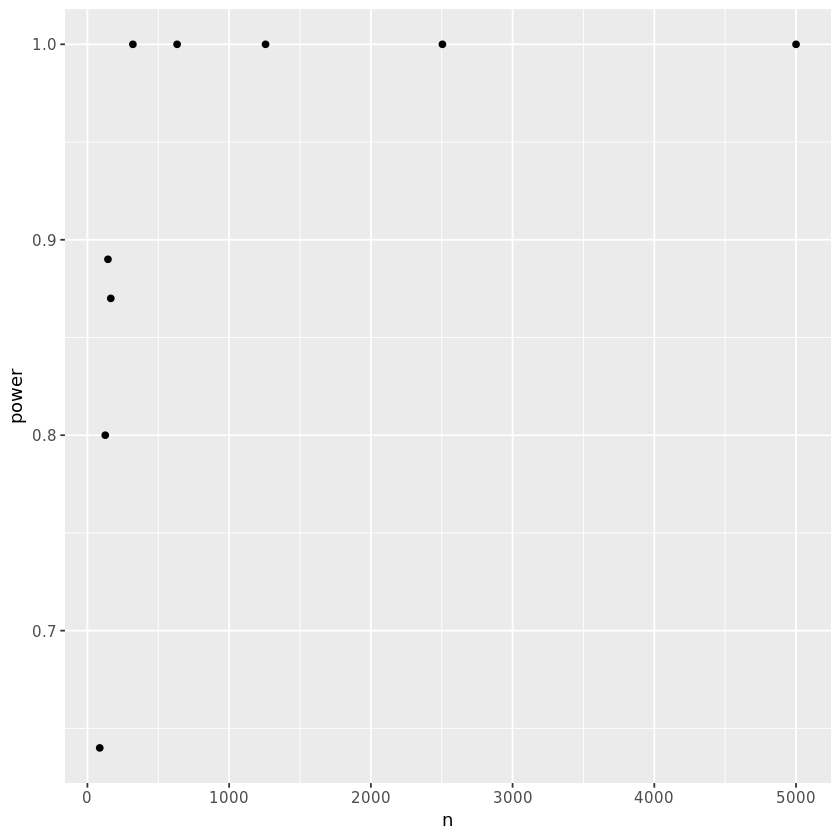

In [122]:
ggplot(power.df, aes(n, power))  +
    geom_point()

In [116]:
power.df

design_label,estimand_label,estimator_label,term,bias,se(bias),rmse,se(rmse),power,se(power),⋯,sd_estimate,se(sd_estimate),mean_se,se(mean_se),type_s_rate,se(type_s_rate),mean_estimand,se(mean_estimand),n_sims,n
design,ate_YA_1_0,estimator,Z1,-0.0006204,0.001881,0.01952,0.001291,1.00,0.00000,⋯,0.02867,0.001585,0.02829,0.0000289,0,0,0.4999,0.002026,100,5000
design,ate_YA_1_0,estimator,Z1,-0.0021332,0.002983,0.02776,0.002526,1.00,0.00000,⋯,0.03981,0.002640,0.03996,0.0000590,0,0,0.4972,0.002507,100,2505
design,ate_YA_1_0,estimator,Z1,0.0049977,0.005156,0.05051,0.003651,1.00,0.00000,⋯,0.06393,0.004514,0.05627,0.0001063,0,0,0.4957,0.004032,100,1257
design,ate_YA_1_0,estimator,Z1,-0.0078377,0.005442,0.05453,0.004576,1.00,0.00000,⋯,0.07249,0.005349,0.07941,0.0002374,0,0,0.4966,0.005491,100,633
design,ate_YA_1_0,estimator,Z1,-0.0091340,0.006472,0.07763,0.004457,1.00,0.00000,⋯,0.10921,0.007328,0.11112,0.0004406,0,0,0.5064,0.007461,100,321
design,ate_YA_1_0,estimator,Z1,0.0010126,0.010157,0.10094,0.008211,0.87,0.03095,⋯,0.15029,0.010417,0.15497,0.0009954,0,0,0.4793,0.011205,100,165
design,ate_YA_1_0,estimator,Z1,-0.0090829,0.016112,0.15065,0.013125,0.64,0.05152,⋯,0.21583,0.014726,0.21181,0.0017182,0,0,0.4939,0.016686,100,87
design,ate_YA_1_0,estimator,Z1,0.0291473,0.013677,0.13828,0.008619,0.80,0.03995,⋯,0.17521,0.012676,0.17861,0.0011298,0,0,0.4966,0.012105,100,126
design,ate_YA_1_0,estimator,Z1,0.0173800,0.011430,0.11211,0.007674,0.89,0.03052,⋯,0.15088,0.009868,0.16502,0.0010163,0,0,0.4946,0.010042,100,145


# You are Free to Copy & Reuse this Code 

Copyright 2019 J. Nathan Matias

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.